# **AI-Powered Personalized News Aggregator**

**Objective**

The goal of this project is to build an AI-powered Personalized News Aggregator that scrapes, filters, summarizes, and recommends news articles based on user preferences. Using Natural Language Processing (NLP) and Machine Learning (ML) techniques, this system enhances user experience by providing concise, relevant, and personalized news summaries.

In [2]:
# Installing necessary Liabaries and framework
!pip install requests pandas newspaper3k flask
!pip install --upgrade lxml lxml_html_clean newspaper3k
!pip install bert-extractive-summarizer
!pip install vaderSentiment

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 8.5 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=08dfc7826dff7df4f2f1ac89e6c20c1d6af6901753e3b474d9cfbfd9f4b09d15
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha256=d0844d4653b1ba550ceee4ab982f49c287999adafb58e4a0abdee316e36ef6c0
  Stored in directory: /root/.cache/pip/wheels/80/d5/72/9cd9eccc819636436c6a6e59c22a0fb1ec

In [3]:
import requests
import pandas as pd
import torch
from transformers import pipeline, BertTokenizer, BertModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **Step 1: News Scraping & Data Collection**





*   **API Used:** NewsAPI.org
*   **Categories Covered:** Technology, Sports, Business, Health, Entertainment, Science, General, World, Politics, Economy, Education, Fashion, Food, Gaming, Music, Travel, Culture, Crime, Weather











In [4]:
API_KEY = "39a756fd47e14a319b24fd51646509ab"
NEWS_API_URL = "https://newsapi.org/v2/top-headlines"

categories = [
    "technology", "business", "sports","health", "entertainment", "science", "general",
    "world", "politics", "economy", "education", "environment", "fashion", "food",
    "gaming", "music", "travel", "culture", "crime", "weather"
]

def fetch_news():
    all_articles = []
    for category in categories:
        params = {"country": "us", "category": category, "apiKey": API_KEY}
        response = requests.get(NEWS_API_URL, params=params)
        data = response.json()

        if "articles" in data:
            for article in data["articles"]:
                all_articles.append({
                    "title": article["title"],
                    "description": article["description"],
                    "url": article["url"],
                    "category": category
                })

    return pd.DataFrame(all_articles)

news_df = fetch_news()
news_df.to_csv("news_data.csv", index=False)
print("News data saved!")
news_df.head()

News data saved!


,title,description,url,category
0,Marvel Rivals' Recent Layoffs Affected 6 Peopl...,"The initial reports about ""significant layoffs...",https://80.lv/articles/marvel-rivals-recent-la...,technology
1,iPhone 16E Name is Increasingly Likely Instead...,Apple is expected to announce a new entry-leve...,https://www.macrumors.com/2025/02/18/iphone-16...,technology
2,Google app on iOS removing Gemini as it pushes...,The Google app for iOS is removing Gemini supp...,http://9to5google.com/2025/02/18/google-app-re...,technology
3,OnePlus Watch 3 is missing an important featur...,The company has come clean about the limitatio...,https://www.gsmarena.com/oneplus_watch_3_is_mi...,technology
4,‘Pokémon Go’ Maker Nears $3.5 Billion Deal to ...,"Niantic Inc., the company behind the 2016 hit ...",https://www.bloomberg.com/news/articles/2025-0...,technology


In [5]:
news_df.shape

(188, 4)

In [6]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        188 non-null    object
 1   description  176 non-null    object
 2   url          188 non-null    object
 3   category     188 non-null    object
dtypes: object(4)
memory usage: 6.0+ KB


In [7]:
news_df['category'].unique()

array(['technology', 'business', 'sports', 'health', 'entertainment',
       'science', 'general', 'politics', 'gaming', 'music'], dtype=object)

In [8]:
# Counting Null Values
news_df.isnull().sum()

,0
title,0
description,12
url,0
category,0


## **Step 2: Filling full content for each article**

In [9]:
from newspaper import Article
import time

def get_full_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return None

# Fetch full content for each article
news_df["full_content"] = news_df["url"].apply(lambda x: get_full_article(x) if x else None)
news_df.to_csv("news_with_content.csv", index=False)
print("Saved full news content!")

Saved full news content!


In [10]:
news_df.head()

,title,description,url,category,full_content
0,Marvel Rivals' Recent Layoffs Affected 6 Peopl...,"The initial reports about ""significant layoffs...",https://80.lv/articles/marvel-rivals-recent-la...,technology,"""We recently made the difficult decision to ad..."
1,iPhone 16E Name is Increasingly Likely Instead...,Apple is expected to announce a new entry-leve...,https://www.macrumors.com/2025/02/18/iphone-16...,technology,Apple is expected to announce a new entry-leve...
2,Google app on iOS removing Gemini as it pushes...,The Google app for iOS is removing Gemini supp...,http://9to5google.com/2025/02/18/google-app-re...,technology,Google is informing iOS users that it will be ...
3,OnePlus Watch 3 is missing an important featur...,The company has come clean about the limitatio...,https://www.gsmarena.com/oneplus_watch_3_is_mi...,technology,Earlier today OnePlus made the Watch 3 officia...
4,‘Pokémon Go’ Maker Nears $3.5 Billion Deal to ...,"Niantic Inc., the company behind the 2016 hit ...",https://www.bloomberg.com/news/articles/2025-0...,technology,None


In [11]:
# Checking count of Null Values
news_df.isnull().sum()

,0
title,0
description,12
url,0
category,0
full_content,25


Filling Null articles

In [12]:
# Dealing with Null values
news_df['full_content'].fillna("Full article unavailable. Click the source link for details.", inplace=True)


<ipython-input-12-8032932a60fc>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  news_df['full_content'].fillna("Full article unavailable. Click the source link for details.", inplace=True)


In [13]:
news_df.isnull().sum()

,0
title,0
description,12
url,0
category,0
full_content,0


## **Step 3: News Summarization**

**Model Used:** facebook/bart-large-cnn (BERT-based text summarization)

In [14]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text):
    if isinstance(text, str) and len(text) > 50:
        return summarizer(text[:1024], max_length=100, min_length=30, do_sample=False)[0]['summary_text']
    return text

news_df["summary"] = news_df["full_content"].apply(summarize_text)
news_df.to_csv("news_data_summarized.csv", index=False)
print("News data summarized!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Your max_length is set to 100, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 100, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 100, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 100, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', 

News data summarized!


In [15]:
news_df.head()

,title,description,url,category,full_content,summary
0,Marvel Rivals' Recent Layoffs Affected 6 Peopl...,"The initial reports about ""significant layoffs...",https://80.lv/articles/marvel-rivals-recent-la...,technology,"""We recently made the difficult decision to ad...","""We recently made the difficult decision to ad..."
1,iPhone 16E Name is Increasingly Likely Instead...,Apple is expected to announce a new entry-leve...,https://www.macrumors.com/2025/02/18/iphone-16...,technology,Apple is expected to announce a new entry-leve...,Apple is expected to announce a new entry-leve...
2,Google app on iOS removing Gemini as it pushes...,The Google app for iOS is removing Gemini supp...,http://9to5google.com/2025/02/18/google-app-re...,technology,Google is informing iOS users that it will be ...,Google is removing Gemini support from the mai...
3,OnePlus Watch 3 is missing an important featur...,The company has come clean about the limitatio...,https://www.gsmarena.com/oneplus_watch_3_is_mi...,technology,Earlier today OnePlus made the Watch 3 officia...,"The Watch 3 has support for ECG readings, but ..."
4,‘Pokémon Go’ Maker Nears $3.5 Billion Deal to ...,"Niantic Inc., the company behind the 2016 hit ...",https://www.bloomberg.com/news/articles/2025-0...,technology,Full article unavailable. Click the source lin...,CNN.com will feature iReporter photos in a wee...


## **Step 4: Sentiment Analysis**

**Tool Used:** VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [16]:
# Step 3: Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if isinstance(text, str):
        score = analyzer.polarity_scores(text)["compound"]
        return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"
    return "Neutral"

news_df["sentiment"] = news_df["summary"].apply(analyze_sentiment)
news_df.to_csv("news_data_sentiment.csv", index=False)
print("Sentiment analysis completed!")

Sentiment analysis completed!


## **Step 5: News Recommendation System**

**Model Used:** Sentence Transformers (all-MiniLM-L6-v2 for BERT embeddings)

In [17]:
#
class NewsRecommender:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
        self.model = BertModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

    def embed_text(self, text):
        tokens = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            output = self.model(**tokens)
        return output.last_hidden_state[:, 0, :].numpy()

    def compute_similarity(self, news_df, user_article_index):
        embeddings = np.vstack(news_df["summary"].apply(self.embed_text).tolist())
        similarities = cosine_similarity([embeddings[user_article_index]], embeddings)[0]
        news_df["similarity"] = similarities
        return news_df.sort_values(by="similarity", ascending=False).head(5)

recommender = NewsRecommender()
news_df.to_csv("news_data_final.csv", index=False)
print("News recommendation system ready!")

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

News recommendation system ready!


In [18]:
news_df.head()

,title,description,url,category,full_content,summary,sentiment
0,Marvel Rivals' Recent Layoffs Affected 6 Peopl...,"The initial reports about ""significant layoffs...",https://80.lv/articles/marvel-rivals-recent-la...,technology,"""We recently made the difficult decision to ad...","""We recently made the difficult decision to ad...",Positive
1,iPhone 16E Name is Increasingly Likely Instead...,Apple is expected to announce a new entry-leve...,https://www.macrumors.com/2025/02/18/iphone-16...,technology,Apple is expected to announce a new entry-leve...,Apple is expected to announce a new entry-leve...,Neutral
2,Google app on iOS removing Gemini as it pushes...,The Google app for iOS is removing Gemini supp...,http://9to5google.com/2025/02/18/google-app-re...,technology,Google is informing iOS users that it will be ...,Google is removing Gemini support from the mai...,Positive
3,OnePlus Watch 3 is missing an important featur...,The company has come clean about the limitatio...,https://www.gsmarena.com/oneplus_watch_3_is_mi...,technology,Earlier today OnePlus made the Watch 3 officia...,"The Watch 3 has support for ECG readings, but ...",Positive
4,‘Pokémon Go’ Maker Nears $3.5 Billion Deal to ...,"Niantic Inc., the company behind the 2016 hit ...",https://www.bloomberg.com/news/articles/2025-0...,technology,Full article unavailable. Click the source lin...,CNN.com will feature iReporter photos in a wee...,Neutral


<ipython-input-19-6d0f458fd4bf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=news_df, x=news_df['sentiment'], palette='cool')
<ipython-input-19-6d0f458fd4bf>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


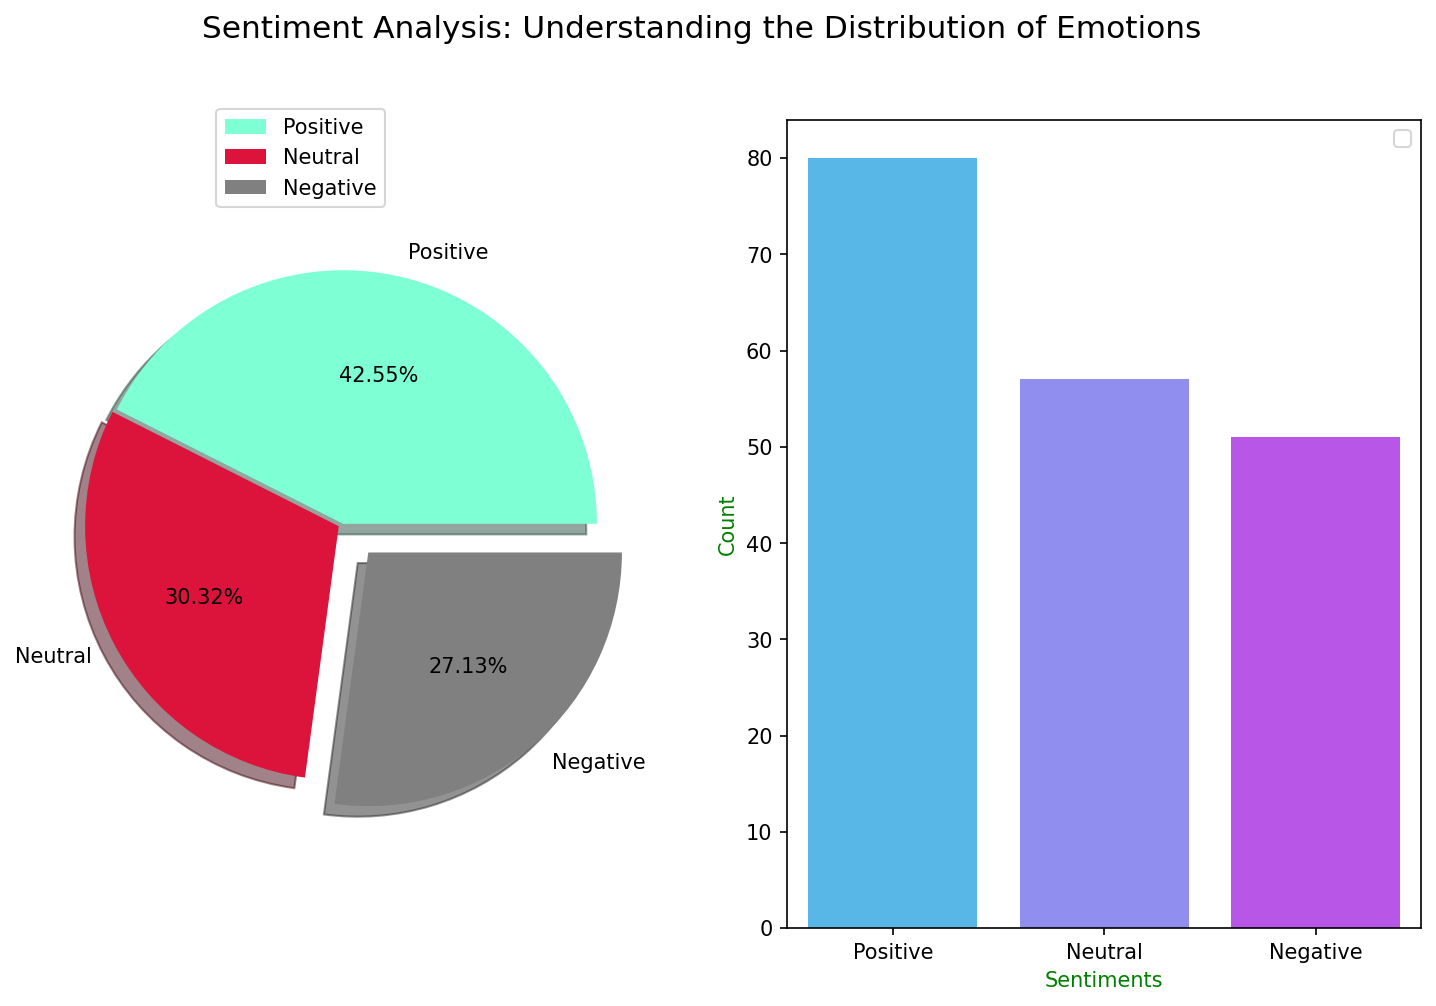

In [19]:
plt.figure(figsize=(12,7),dpi=150)

plt.subplot(1,2,1)
size=news_df['sentiment'].value_counts()
color='aquamarine','Crimson','Grey'
label= ['Positive','Neutral','Negative']
explode=[0.0,0.02,0.15]
plt.pie(size, colors=color, explode=explode, labels=label, autopct="%.2f%%", shadow=True)
plt.legend(loc=[0.3,1])

plt.subplot(1,2,2)
sns.countplot(data=news_df, x=news_df['sentiment'], palette='cool')
plt.suptitle("Sentiment Analysis: Understanding the Distribution of Emotions", fontsize=15, color='black' )
plt.xlabel("Sentiments",color='g')
plt.ylabel('Count',color='g')
plt.legend()
plt.show()

**Key Takeaways:**

Positive sentiment dominates – Almost half of the responses are positive, indicating a generally favorable reaction.

Neutral sentiment is significant – Over 30% of responses fall in the neutral category, suggesting a balanced mix of opinions.

Negative sentiment is the lowest – Only 27% of responses are negative, showing that dissatisfaction or unfavorable opinions are in the minority.


 ## **Outcome**



*   Successfully built a Personalized News Aggregator that:

*   Scrapes, summarizes, and categorizes news articles.

*   Conducts sentiment analysis to help users gauge article tone.
*   Uses AI-driven recommendations to suggest relevant articles based on user preferences.


*   Provides a scalable and customizable framework for real-time news processing.











